<a href="https://colab.research.google.com/github/abdelh17/COMP432-GroupG/blob/main/432_project_GroupG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries


In [ ]:
# import libraries
from PIL import Image, ImageOps, ImageEnhance
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import zipfile
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.manifold import TSNE
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns

# Data loading, preprocessing and basic visualization

## Extract Datasets and apply transforms




In [ ]:
# the 3 datasets can be found in the zip file in this drive document
!gdown 1wK7-PccXDY7tGTzQpwLD7Ok1krBxcvhi

Downloading...
From: https://drive.google.com/uc?id=1wK7-PccXDY7tGTzQpwLD7Ok1krBxcvhi
To: /content/project_datasets.zip
100% 1.23G/1.23G [00:10<00:00, 113MB/s]


In [ ]:
zip_file_path = 'project_datasets.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

# names of the datasets
extracted_dirs = ['d1_colorectal_cancer', 'd2_prostate_cancer', 'd3_animal_faces']
# dictionary of datasets
datasets_dict = {}


In [ ]:
# resize, make tensor, normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)), #for resnet18
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# applies transformations and adds subfolder in the dictionary
for dir_name in extracted_dirs:
    dataset_path = os.path.join('project_datasets/', dir_name)
    if os.path.exists(dataset_path):
        datasets_dict[dir_name] = datasets.ImageFolder(dataset_path, transform=transform)
    else:
        print(f"The directory {dataset_path} does not exist.")

## Display one image of each


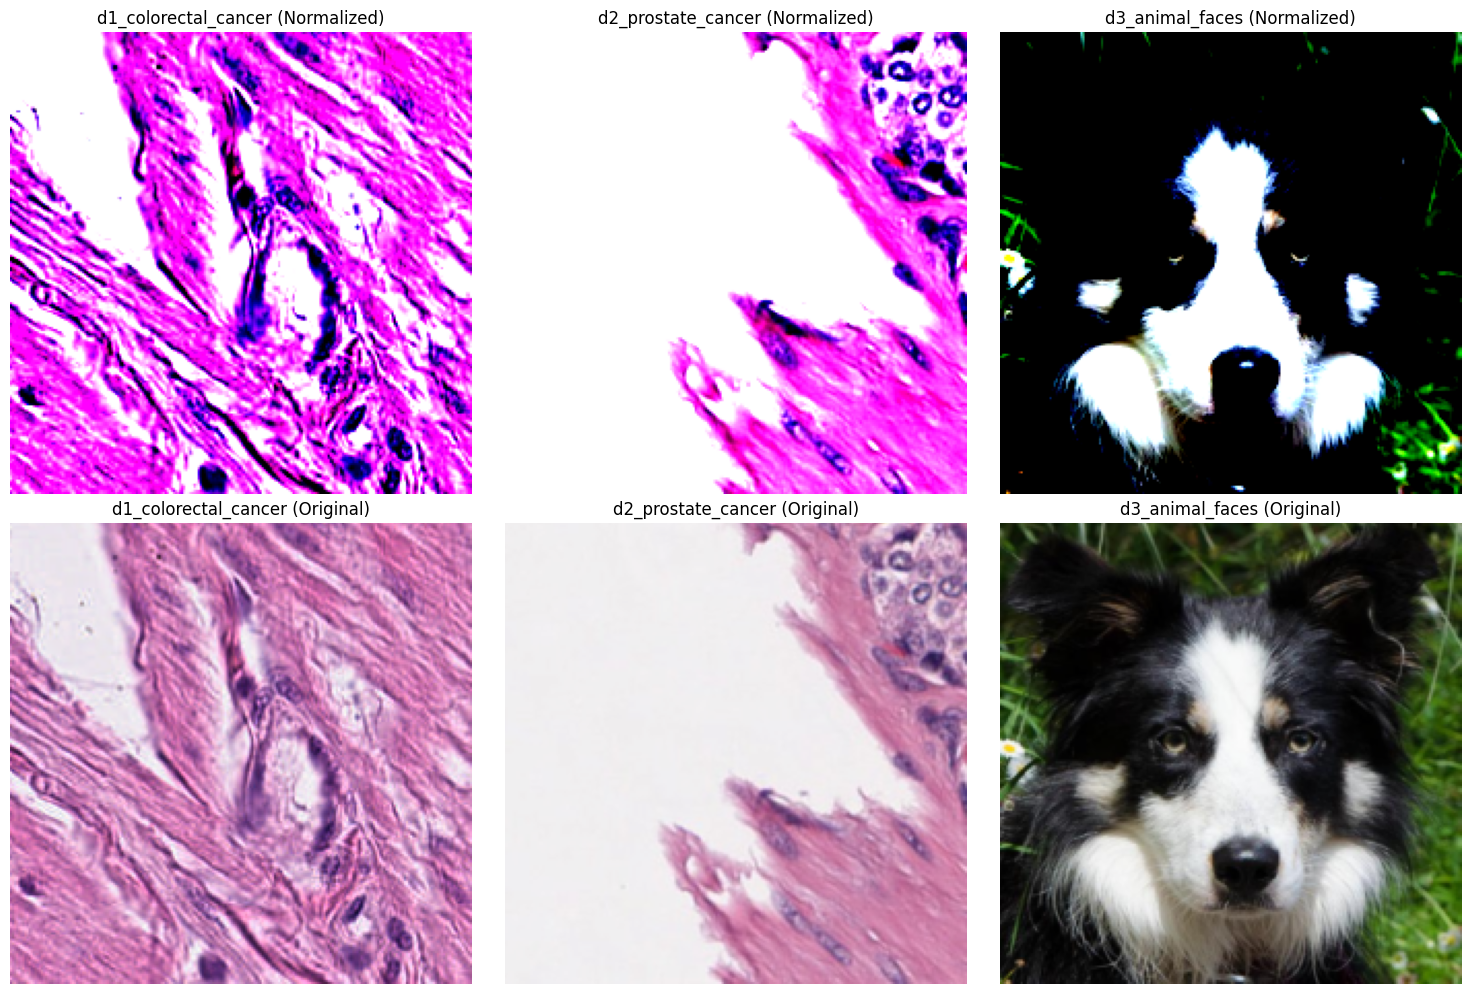

In [ ]:
# need to unnormalize to show the original image since it was normalized in the previous step
def unnormalize(img_tensor):
    img = img_tensor.clone()  # Clone the tensor to avoid modifying it
    img = img.numpy().transpose((1, 2, 0))  # Convert from tensor image

    # unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean  # Apply the reverse of normalization
    img = np.clip(img, 0, 1)

    return img

# plotting
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

dataset_names = list(datasets_dict.keys())

for j in range(3):
    dataset_name = dataset_names[j]
    dataset = datasets_dict[dataset_name]

    # randomly choose image in dataset
    img_tensor, _ = random.choice(dataset)

    # display normalized image
    axs[0, j].imshow(img_tensor.permute(1, 2, 0))
    axs[0, j].set_title(f"{dataset_name} (Normalized)")
    axs[0, j].axis('off')

    # display original image
    unorm_img = unnormalize(img_tensor)

    axs[1, j].imshow(unorm_img)
    axs[1, j].set_title(f"{dataset_name} (Original)")
    axs[1, j].axis('off')

plt.tight_layout()
plt.show()


# Task 1

## Initialization

In [ ]:
batch_size = 32

dataset_colorectal = datasets_dict['d1_colorectal_cancer']

train_size = int(0.7 * len(dataset_colorectal))
test_size = len(dataset_colorectal) - train_size

train_dataset, test_dataset = random_split(dataset_colorectal, [train_size, test_size])
indices = list(range(100))

colorectal_loader = DataLoader(dataset_colorectal, batch_size=batch_size, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

subset_test_dataset = Subset(test_dataset, indices)
test_loader_100 = DataLoader(subset_test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# use untrained ResNet model
model = resnet18(weights=None)

# outputs of the layer before the fc layer (512)
num_ftrs = model.fc.in_features

# remove fully connected layer for feature extraction
model.fc = nn.Identity()

# add fc for predictions
num_classes = 3
model.fc_pred = nn.Linear(in_features=num_ftrs, out_features=num_classes)

model.to(device)

Using device: cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Training custom ResNet-18 on colorectal cancer dataset

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.7)

# learning rate is modified by a factor of 0.1 each 5 epochs
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 10

# for plotting accuracy and loss
epoch_accuracies=[]
epoch_losses=[]

# training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    # calculate 1 epoch time
    if epoch == 0:
      start_time = time.time()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() #zero the previous gradients

        outputs = model(inputs)
        predictions = model.fc_pred(outputs)
        loss = criterion(predictions, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(predictions, 1)
        running_corrects += torch.sum(preds == labels.data)

    if epoch == 0:
      end_time = time.time()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = running_corrects.double() / len(train_loader.dataset)

    epoch_accuracies.append(epoch_accuracy.item())
    epoch_losses.append(epoch_loss)

    scheduler.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy*100:.2f}%')
print(f"Wall clock time for one epoch: {end_time-start_time}")

Epoch 1/10, Train Loss: 0.5694, Train Accuracy: 75.50%
Epoch 2/10, Train Loss: 0.3453, Train Accuracy: 86.40%
Epoch 3/10, Train Loss: 0.2447, Train Accuracy: 90.74%
Epoch 4/10, Train Loss: 0.2140, Train Accuracy: 92.45%
Epoch 5/10, Train Loss: 0.2017, Train Accuracy: 93.07%
Epoch 6/10, Train Loss: 0.0956, Train Accuracy: 96.93%
Epoch 7/10, Train Loss: 0.0861, Train Accuracy: 97.21%
Epoch 8/10, Train Loss: 0.0716, Train Accuracy: 97.76%
Epoch 9/10, Train Loss: 0.0746, Train Accuracy: 97.07%
Epoch 10/10, Train Loss: 0.0777, Train Accuracy: 97.19%
Wall clock time for one epoch: 28.481356859207153


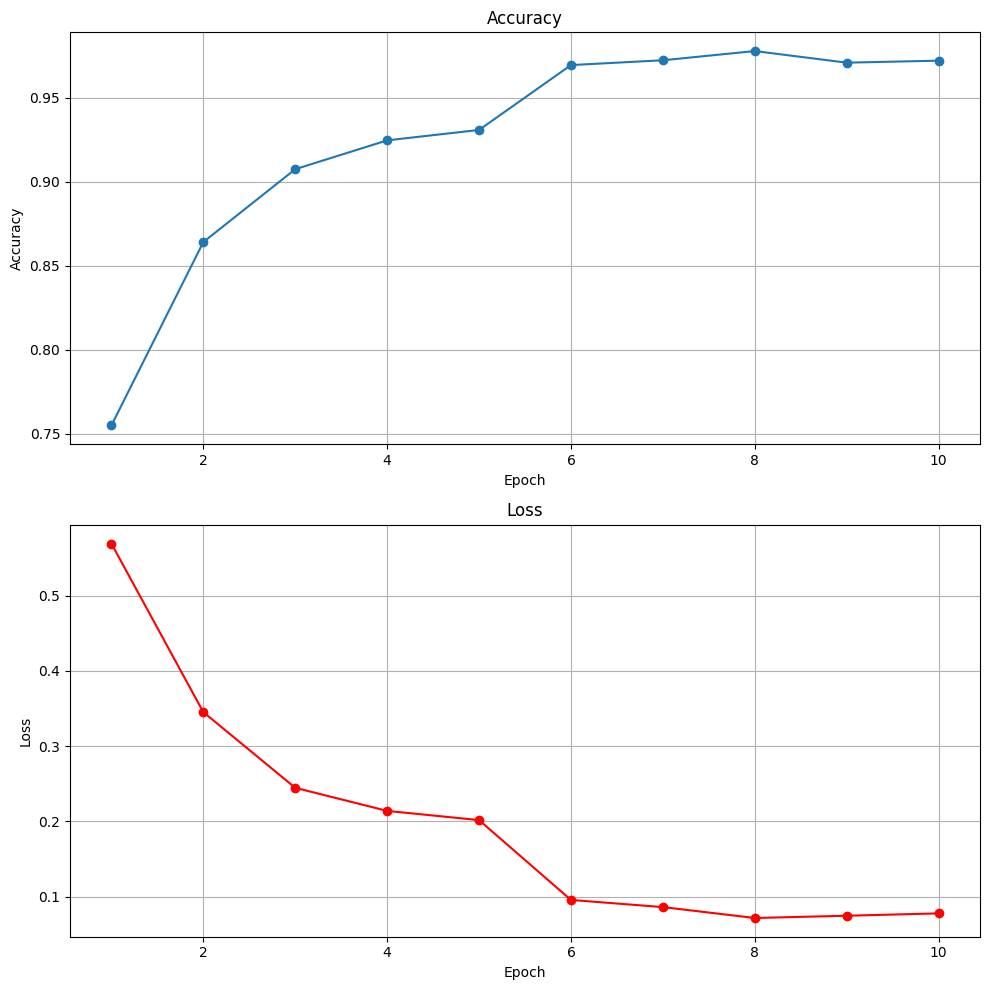

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(range(1, num_epochs + 1), epoch_accuracies, marker='o')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', color='r')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()

plt.show()


## Evaluation

In [ ]:
# testing loop
model.eval() #won't compute gradients
test_loss = 0.0
total = 0
correct = 0

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        predictions = model.fc_pred(outputs)
        loss = criterion(predictions, labels)
        test_loss += loss.item()

        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # needed for recall and precision
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

test_accuracy = correct / total
print(f'Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')


Test Loss: 0.0532, Test Accuracy: 98.33%


In [ ]:
# calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

Precision: 0.9834, Recall: 0.9833, F1-Score: 0.9833


## Visualization of features

**Feature extraction**


In [ ]:
def extract_features(model, data_loader):
    model.eval()

    all_features = []
    all_true_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # extract features
            outputs = model(inputs)

            all_features.extend(outputs.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # convert features to a np array
    all_features_array = np.array(all_features)
    all_labels_array = np.array(all_true_labels)

    return all_features_array, all_labels_array


**function to visualize the extracted features**

In [ ]:
def visualize_tsne(features, labels, title):
  # apply tSNE for dimensionality reduction
    features_tsne = TSNE(n_components=2, random_state=42).fit_transform(features)

    # plot
    plt.figure(figsize=(10, 8))
    plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar()
    plt.title(f"{title}")
    plt.axis("off")
    plt.show()

In [ ]:
colorectal_features, colorectal_labels = extract_features(model, colorectal_loader)

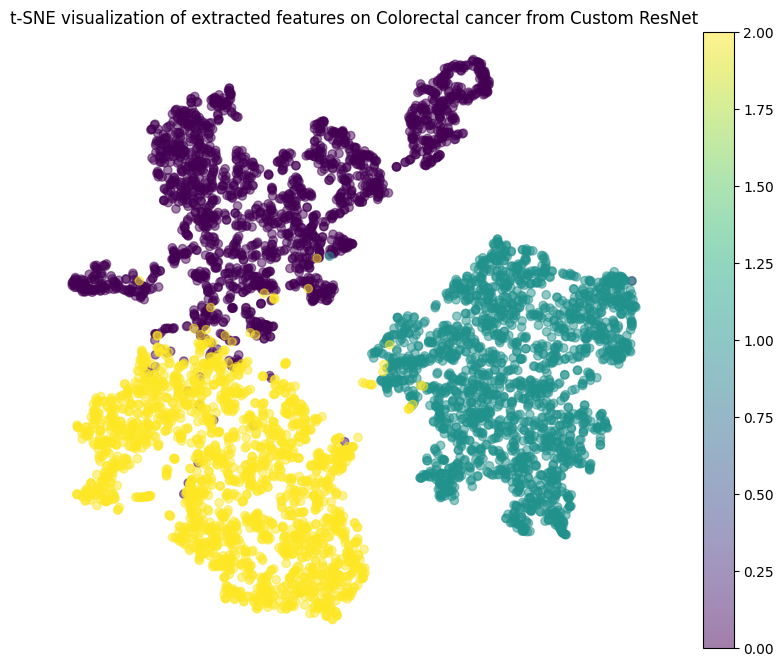

In [ ]:
visualize_tsne(colorectal_features, colorectal_labels, title="t-SNE visualization of extracted features on Colorectal cancer from Custom ResNet")

**Class 0 - PURPLE - MUS  
Class 1 - BLUE-GREEN - NORM  
Class 2 - YELLOW - STR**

# Task 2

## Loaders datasets 2-3

In [ ]:
batch_size = 32

dataset_prostate = datasets_dict['d2_prostate_cancer']

dataloader_prostate = DataLoader(dataset_prostate,batch_size=batch_size, shuffle=False)

dataset_animals = datasets_dict['d3_animal_faces']

dataloader_animals = DataLoader(dataset_animals,batch_size=batch_size, shuffle=False)

## Apply t-SNE reduction and visualize extracted features with the custom ResNet-18

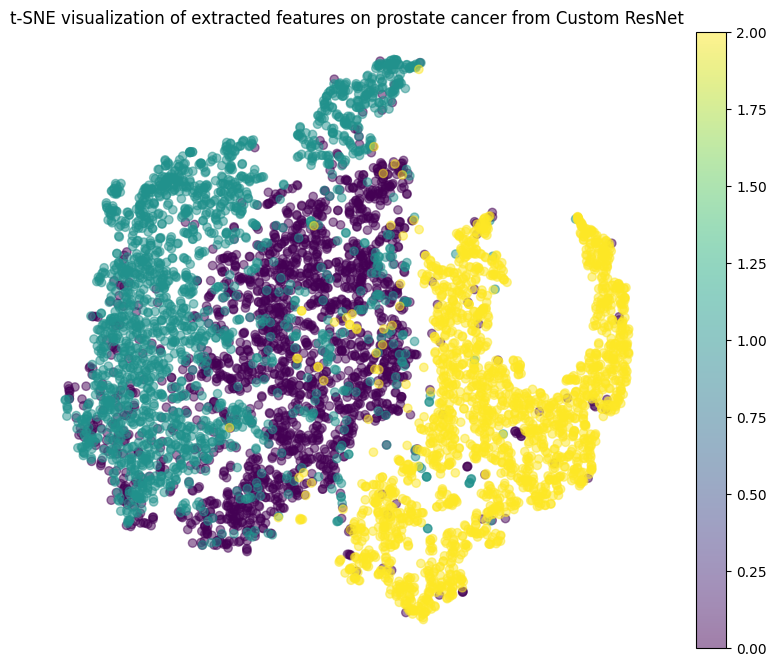

In [ ]:
prostate_features, prostate_labels = extract_features(model, dataloader_prostate)
visualize_tsne(prostate_features, prostate_labels,  title = "t-SNE visualization of extracted features on prostate cancer from Custom ResNet")

**Class 0 - PURPLE - GLAND  
Class 1 - BLUE-GREEN - NONGLAND  
Class 2 - YELLOW - TUMOR**

**We can see the plot differentiates between the three clases, with some overlap. The classes are generally in the same cluster, even though the clusters overlap.**

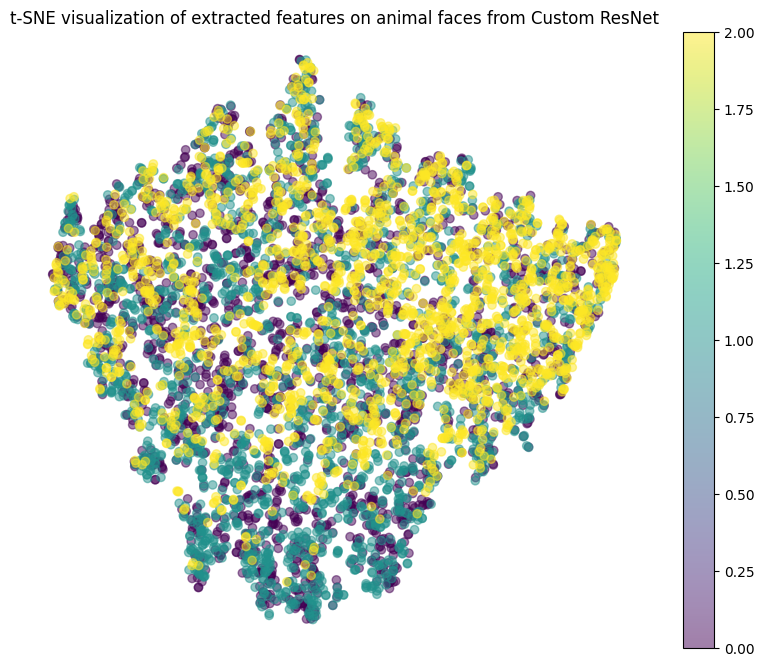

In [ ]:
animals_features, animals_labels = extract_features(model, dataloader_animals)
visualize_tsne(animals_features, animals_labels, "t-SNE visualization of extracted features on animal faces from Custom ResNet")

**Class 0 - PURPLE - CAT  
Class 1 - BLUE-GREEN - DOG  
Class 2 - YELLOW - WILD**

**The three classes (dog, cat, wildlife), are not differentiable one from the other with the tSNE plot of the extracted features with our custom ResNet.**

## Apply t-SNE reduction and visualize extracted features with the ImageNet ResNet-18 pretrained model

In [ ]:
imagenet_model = resnet18(weights='IMAGENET1K_V1').to(device)

# remove fully connected layer
imagenet_model.fc = torch.nn.Identity()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


In [ ]:
prostate_features_imagenet, prostate_labels_imagenet = extract_features(imagenet_model, dataloader_prostate)

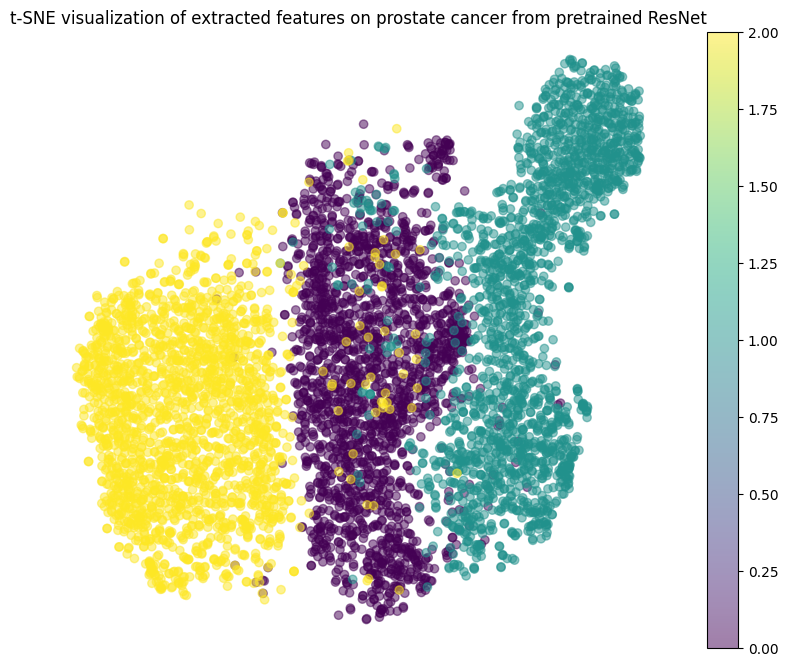

In [ ]:
visualize_tsne(prostate_features_imagenet, prostate_labels_imagenet, title = "t-SNE visualization of extracted features on prostate cancer from pretrained ResNet")

**Class 0 - PURPLE - GLAND  
Class 1 - BLUE-GREEN - NONGLAND  
Class 2 - YELLOW - TUMOR**

In [ ]:
animals_features_imagenet, animals_labels_imagenet = extract_features(imagenet_model, dataloader_animals)

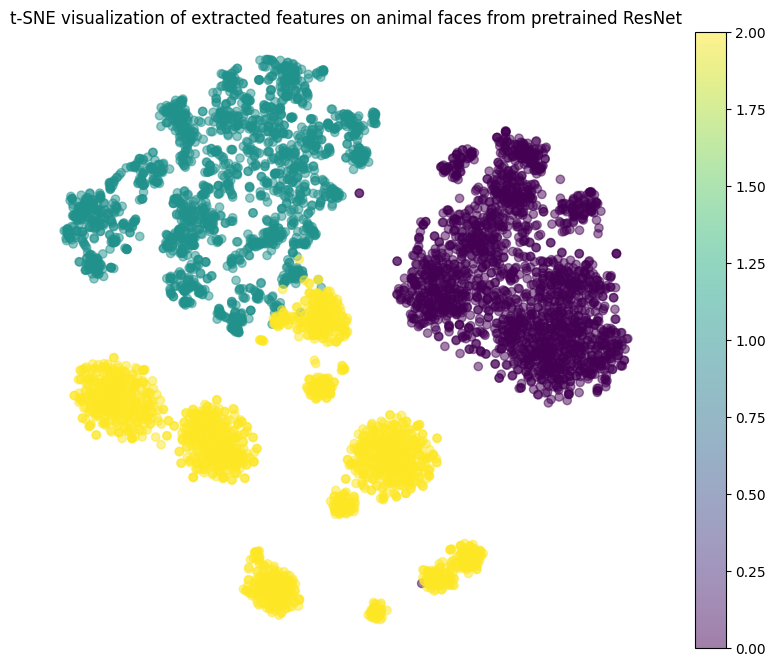

In [ ]:
visualize_tsne(animals_features_imagenet, animals_labels_imagenet, title = "t-SNE visualization of extracted features on animal faces from pretrained ResNet")

**Class 0 - PURPLE - CAT  
Class 1 - BLUE-GREEN - DOG  
Class 2 - YELLOW - WILD**

## Apply KNN and SVM on prostate features from the ImageNet pretrained CNN

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(prostate_features_imagenet, prostate_labels_imagenet, test_size=0.3)

# train KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_features, train_labels)

# train SVM
svm = SVC(kernel='rbf')
svm.fit(train_features, train_labels)

# predict
knn_predictions = knn.predict(test_features)
svm_predictions = svm.predict(test_features)
# evaluate
print("KNN Classification Report:")
print(classification_report(test_labels, knn_predictions))

print("SVM Classification Report:")
print(classification_report(test_labels, svm_predictions))

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       597
           1       0.98      0.93      0.95       604
           2       0.99      0.94      0.97       599

    accuracy                           0.95      1800
   macro avg       0.95      0.95      0.95      1800
weighted avg       0.95      0.95      0.95      1800

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       597
           1       0.97      0.98      0.98       604
           2       1.00      0.98      0.99       599

    accuracy                           0.98      1800
   macro avg       0.98      0.98      0.98      1800
weighted avg       0.98      0.98      0.98      1800



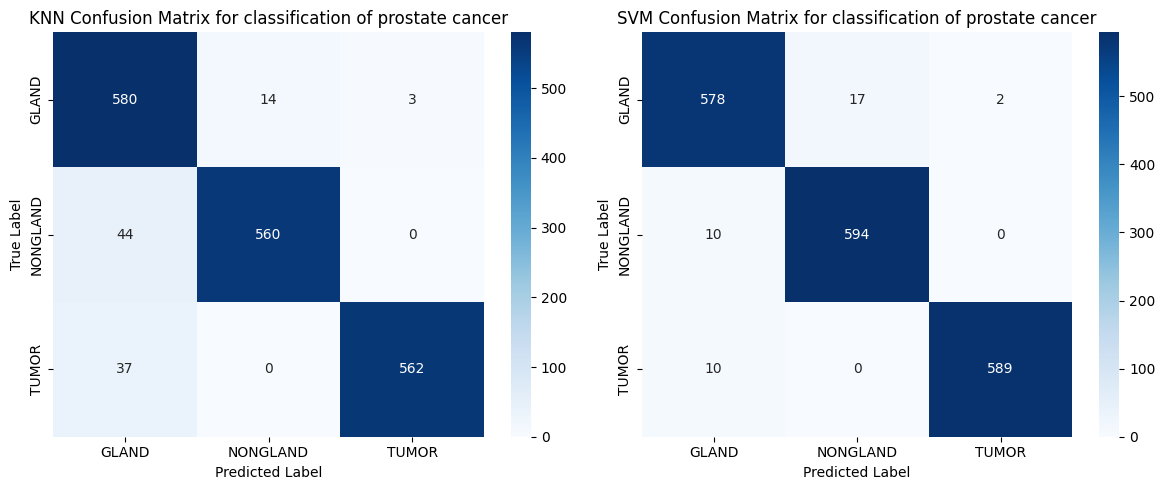

In [ ]:
fig=plt.figure(figsize=(12, 5))

labels=["GLAND", "NONGLAND", "TUMOR"]

# KNN
knn_cm = confusion_matrix(test_labels, knn_predictions)
plt.subplot(1, 2, 1)
sns.heatmap(knn_cm, annot=True,fmt="d", cmap="Blues", xticklabels=labels,yticklabels=labels)
plt.title("KNN Confusion Matrix for classification of prostate cancer")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# SVM
svm_cm = confusion_matrix(test_labels, svm_predictions)
plt.subplot(1, 2, 2)
sns.heatmap(svm_cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels,yticklabels=labels)
plt.title("SVM Confusion Matrix for classification of prostate cancer")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.tight_layout()
plt.show()

# Evaluation on 100 images dataset

In [ ]:
# testing loop
model.eval() #won't compute gradients
test_loss = 0.0
total = 0
correct = 0

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in test_loader_100:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        predictions = model.fc_pred(outputs)
        loss = criterion(predictions, labels)
        test_loss += loss.item()

        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # needed for recall and precision
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

test_accuracy = correct / total
print(f'Test Loss: {test_loss / len(test_loader_100):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')


In [ ]:
# calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')

print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')